In [5]:
import numpy as np
import pyoscode
from scipy import special as sp
import matplotlib
import matplotlib.pyplot as plt

# Table of contents

- Introduction to pyoscode
- The Airy equation
    - Basic functionality
    - Dense output
    - All about arrays
        - Unevenly sampling
        - Logarithmic $\omega$, $\gamma$
        - How do I set the sampling density?

# Introduction to pyoscode

`pyoscode` is a generic-purpose ordinary differential equation (ODE) solver made for equations of the form

$$ \ddot{x} + 2\gamma(t)\dot{x} + \omega^2(t)x = 0, $$

where we want to seek the scalar-valued function $x(t)$, $\gamma(t)$ is a time-dependent "friction" term, and $\omega(t)$ is a time-dependent frequency.

`pyoscode` has a single command, `solve()`. Using `pyoscode` to solve equations thus boils down to three steps:

1. defining the equation,
2. defining the integration range and initial conditions,
3. and extracting the solution and other statistics from the run.

Defining the equation is through specifying the terms $\gamma(t)$ and $\omega(t)$, as `numpy` arrays. The rest of the interface mimics that of [`scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#r179348322575-2):

In [3]:
help(pyoscode.solve)

Help on function solve in module pyoscode:

solve(ts, ws, gs, ti, tf, x0, dx0, t_eval=[], logw=False, logg=False, order=3, rtol=0.0001, atol=0.0, h=None, full_output='', even_grid=False, check_grid=False)
    Solve a differential equation with the RKWKB method.
    
    Parameters
    ----------
    ts: numpy.ndarray [float] or list [float]
       An array of real numbers representing the values of the independe
       nt variable at which the frequency and friction term are evaluated. 
    
    ws: numpy.ndarray [complex] or list [complex]
       An array-like object of real or complex 
       numbers, representing the values of frequency w at the points given in ts.
    
    gs: numpy.ndarray [complex] or list [complex]
        An array-like object of real or complex numbers representing the values
        of the friction term g at the points given in ts.
    
    ti,tf: float
        Start and end of integration range.
    
    x0, dx0: complex
        Initial values of the dependen

Let's see how it works through some examples.

##  The Airy equation

$$ \ddot{x} + tx = 0 $$

The analytic solution is:

<IPython.core.display.Javascript object>


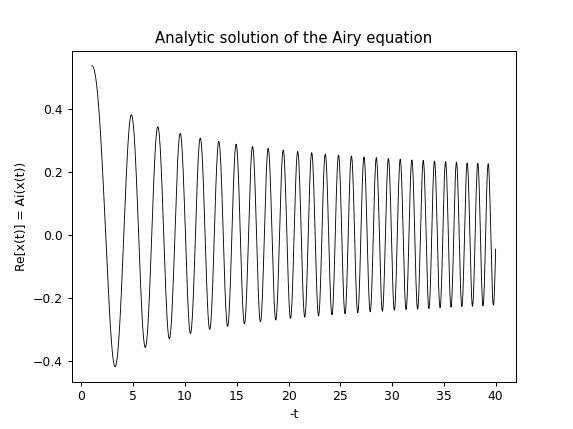

In [12]:
%matplotlib notebook

t_ana = np.linspace(1, 40, 1000)
x_ana = np.asarray([sp.airy(-t)[0] + 1j*sp.airy(-t)[2] for t in t_ana])
plt.figure()
plt.plot(t_ana, x_ana.real,'black',lw=0.7)
plt.title('Analytic solution of the Airy equation')
plt.xlabel('-t')
plt.ylabel('Re[x(t)] = Ai(x(t))')
plt.show()

### Basic functionality

To define the equation, we will need to define
$$\omega(t) = \sqrt{t},$$
$$\gamma(t) = 0$$
as arrays on an array of timepoints:

In [15]:
t = np.linspace(0, 40, 5000)
w = np.sqrt(t)
g = np.zeros_like(t)

Let's then define an integration range and some initial conditions. Let's assume for now that we want the solution at the end of the integration range only.

In [14]:
ti = t_ana[0] # 1.0
tf = t_ana[-1] # 40.0
x0 = sp.airy(-ti)[0] + 1j*sp.airy(-ti)[2]
dx0 = -sp.airy(-ti)[1] - 1j*sp.airy(-ti)[3]

All there's left to do is call `solve()`:

In [17]:
solution = pyoscode.solve(t, w, g, ti, tf, x0, dx0)

and extract the solution. Since we didn't specify we wanted dense output (more about that later), within the integration range we will only get the solution at the internal steps `pyoscode` took, but this set of steps is **guaranteed** to contain `ti` and `tf`.

In [19]:
t_num = np.asarray(solution['t'])
x_num = np.asarray(solution['sol'])

Let's plot this on top of the analytic solution:

<IPython.core.display.Javascript object>


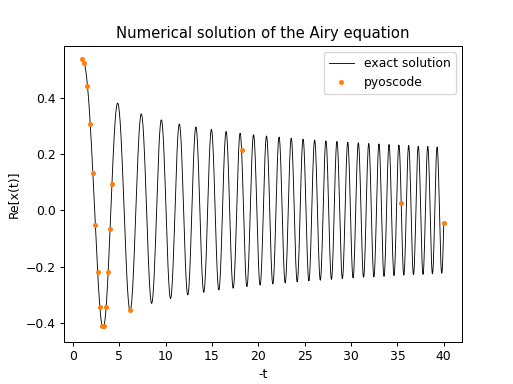

In [24]:
plt.figure()
plt.plot(t_ana, x_ana.real,'black',lw=0.7, label='exact solution')
plt.plot(t_num, x_num.real,'.',color='C1', label='pyoscode')
plt.title('Numerical solution of the Airy equation')
plt.xlabel('-t')
plt.ylabel('Re[x(t)]')
plt.legend()
plt.show()

We can also extract information about the run, like the types of steps taken by `pyoscode`:

<IPython.core.display.Javascript object>


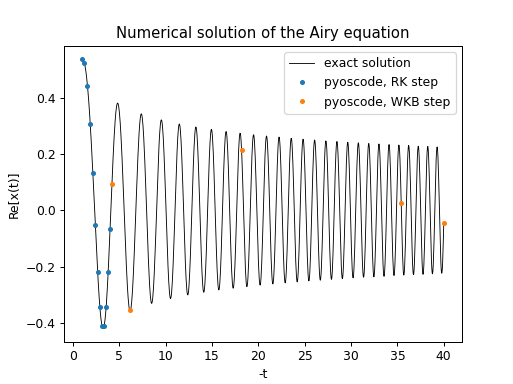

In [25]:
types = np.asarray(solution['types'])
plt.figure()
plt.plot(t_ana, x_ana.real,'black',lw=0.7, label='exact solution')
plt.plot(t_num[types==0], x_num.real[types==0],'.',color='C0', label='pyoscode, RK step')
plt.plot(t_num[types==1], x_num.real[types==1],'.',color='C1', label='pyoscode, WKB step')
plt.title('Numerical solution of the Airy equation')
plt.xlabel('-t')
plt.ylabel('Re[x(t)]')
plt.legend()
plt.show()

### Dense output

Sometimes we don't just need the solution at the end of the integration range. The user can specify specific points at which they wish the solution to be returned, at little extra computational cost (i.e. no extra steps, or evaluations of the terms in the ODE):

<IPython.core.display.Javascript object>


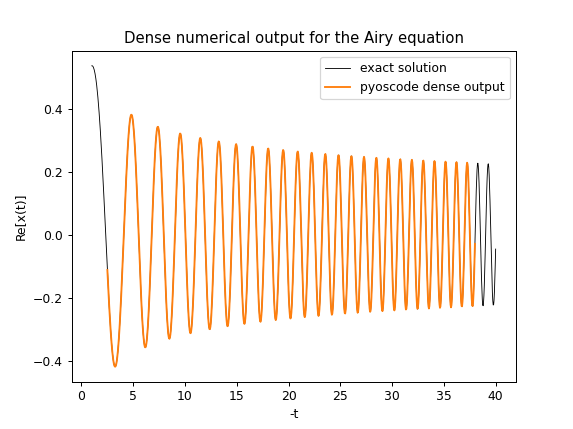

In [33]:
t_eval = np.linspace(2.5, 38.0, 800)

dense_solution = pyoscode.solve(t, w, g, ti, tf, x0, dx0, t_eval=t_eval)
x_eval = np.asarray(dense_solution['x_eval'])

plt.figure()
plt.plot(t_ana, x_ana.real,'black',lw=0.7, label='exact solution')
plt.plot(t_eval, x_eval.real,color='C1', label='pyoscode dense output')
plt.title('Dense numerical output for the Airy equation')
plt.xlabel('-t')
plt.ylabel('Re[x(t)]')
plt.legend()
plt.show()

### All about arrays

#### Uneven sampling

In all examples above, `np.linspace` was used to define the input arrays for $\omega(t)$ and $\gamma(t)$, i.e. they were spaced evenly. This is **not** a requirement, but feeding evenly-sampled arrays and setting the keyword argument `even_grid=True` will give a slight speedup, due to interpolation on the array being faster. If `even_grid` is not set, `pyoscode` will assume the arrays aren't evenly sampled, like so:

In [41]:
# Define arrays for w, g
t_log = np.logspace(0, np.log(40.0), 5000)
w  = np.sqrt(t_log)
g = np.zeros_like(t_log)

# Solve
solution2 = pyoscode.solve(t_log, w, g, ti, tf, x0, dx0, t_eval=t_eval)

# Extract solution
t_num_log = np.asarray(solution2['t'])
x_log = np.asarray(solution2['sol'])
dense_log = np.asarray(solution2['x_eval'])
types_log = np.asarray(solution2['types'])

# Plot (if you like)
#plt.figure()
#plt.plot(t_ana, x_ana.real,'black',lw=0.7, label='exact solution')
#plt.plot(t_eval, dense_log.real,color='C2', label='pyoscode dense output')
#plt.plot(t_num_log[types_log==0], x_log.real[types_log==0],'.',color='C0', label='pyoscode, RK step')
#plt.plot(t_num_log[types_log==1], x_log.real[types_log==1],'.',color='C1', label='pyoscode, WKB step')
#plt.title('Logarithmically sampled input arrays')
#plt.xlabel('-t')
#plt.ylabel('Re[x(t)]')
#plt.legend()
#plt.show()

#### Logarithmic $\omega$, $\gamma$

`pyoscode` has to perform (linear) interpolation on the arrays provided to get $\omega(t)$, $\gamma(t)$ at an arbitrary point with reasonable accuracy. It may be that $\omega(t)$ would have to be very finely sampled for this purpose, but $\log{\omega}(t)$  wouldn't, so letting `pyoscode` perform interpolation on $\log{\omega}$ would make more sense. 

This is possible via setting `logw=True` (and similarly for $\gamma$):

In [42]:
# Logarithm of w
logw = 1./2*np.log(t)

# Solve
solution3 = pyoscode.solve(t, logw, g, ti, tf, x0, dx0, t_eval = t_eval, logw=True)

# Extract solution
t_num_log = np.asarray(solution3['t'])
x_log = np.asarray(solution3['sol'])
dense_log = np.asarray(solution3['x_eval'])
types_log = np.asarray(solution3['types'])

# Plot (if you like)
#plt.figure()
#plt.plot(t_ana, x_ana.real,'black',lw=0.7, label='exact solution')
#plt.plot(t_eval, dense_log.real,color='C2', label='pyoscode dense output')
#plt.plot(t_num_log[types_log==0], x_log.real[types_log==0],'.',color='C0', label='pyoscode, RK step')
#plt.plot(t_num_log[types_log==1], x_log.real[types_log==1],'.',color='C1', label='pyoscode, WKB step')
#plt.title('Logarithmically sampled input arrays')
#plt.xlabel('-t')
#plt.ylabel('Re[x(t)]')
#plt.legend()
#plt.show()

<ipython-input-42-28911f6bfb01>:2: RuntimeWarning: divide by zero encountered in log
  logw = 1./2*np.log(t)


#### How do I set the sampling density?

The eagle-eyed may have spotted that the arrays for $\omega$ and $\gamma$ used so far have been very finely sampled. This is because `pyoscode` has to linearly interpolate on these arrays and achieve reasonable accuracy. If in doubt, plot your $\omega$ and $\gamma$, and ask

- if $\omega(t)$ is slowly changing for at least part of the integration range (`pyoscode` will work best if so)
- if with the given samples it would be possible to get an accurate (at least ~1 in 10^5) result between sample points via linear interpolation.

You could also ask `pyoscode` to perform a rudimentary check for you by turning on `check_grid=True`:

/home/fruzsina/all-virtual-envs/oscode-pip-test/lib/python3.8/site-packages/pyoscode/__init__.py:96: RuntimeWarning: One or more of the arrays provided (w, g, logw, logg) may not be fine enough to carry out linear interpolation accurately. This may result in not traversing oscillatory regions of the solution efficiently and numerical inaccuracies. Please consider refining the sampling of the array(s) or switching to a more suitable independent variable.
  resdict = _pyoscode.solve(ts, ws, gs, ti, tf, x0, dx0, t_eval=t_eval, logw=logw, logg=logg,


<IPython.core.display.Javascript object>


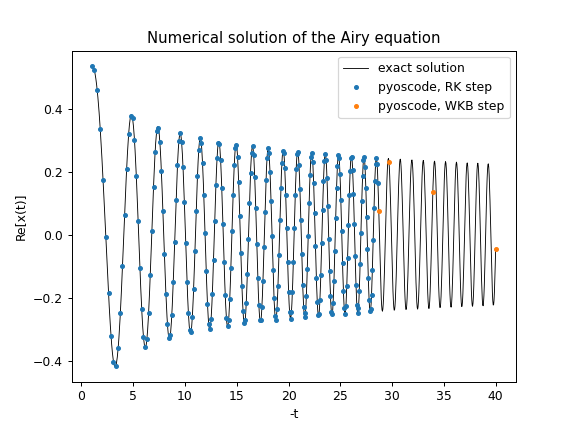

In [46]:
# Define some undersampled arrays for w, g
t = np.linspace(0, 40, 500)
w = np.sqrt(t)
g = np.zeros_like(t)

# Solve
solution4 = pyoscode.solve(t, w, g, ti, tf, x0, dx0, check_grid=True)

# Extract solution 
t_num = np.asarray(solution4['t'])
x_num = np.asarray(solution4['sol'])
types = np.asarray(solution4['types'])


# Plot
plt.figure()
plt.plot(t_ana, x_ana.real,'black',lw=0.7, label='exact solution')
plt.plot(t_num[types==0], x_num.real[types==0],'.',color='C0', label='pyoscode, RK step')
plt.plot(t_num[types==1], x_num.real[types==1],'.',color='C1', label='pyoscode, WKB step')
plt.title('Numerical solution of the Airy equation')
plt.xlabel('-t')
plt.ylabel('Re[x(t)]')
plt.legend()
plt.show()

Undersampling will cause:

- a warning to be raised,
- an overabundance of RK steps (`pyoscode` will not deem it possible to jump through many oscillations while maintaining accuracy)
- loss of accuracy